In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.model_selection import StratifiedKFold
import threading
import time

In [3]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

Лабораторная работа 2


Выполнил Лунгу Н.А. Группа 214-341

---

Используя методы параллельного программирования разработать программу реализации одной из задач обработки больших данных (прогнозирование, выявление зависимости параметров и т.д.).

Этот набор данных содержит информацию о подержанных автомобилях.
Столбцы в данном наборе данных следующие:

* имя
* год
* цена продажи
* пробег
* топливо
* тип продавца
* коробка передач
* владелец

In [27]:
dataset = pd.read_csv("/content/drive/MyDrive/datasets/Car details v3.csv")

In [ ]:
dataset.head(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0


In [28]:
# удалим колонки имени и показатели крутящего момента
dataset.drop(columns=['torque','name'],axis=1,inplace=True)

In [29]:
# посмотрим на пропуски значений
dataset.isnull().any()

year             False
selling_price    False
km_driven        False
fuel             False
seller_type      False
transmission     False
owner            False
mileage           True
engine            True
max_power         True
seats             True
dtype: bool

In [ ]:
# размер датасета
dataset.shape

(8128, 11)

In [30]:
# удаляем строки с пропущенными значениями
dataset = dataset.dropna()

In [ ]:
# после чистки пустых значений - потеряли около 200 значений
dataset.shape

(7907, 11)

In [ ]:
# типы колонок
dataset.dtypes

year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
seats            float64
dtype: object

In [31]:
# уберем суффиксы
dataset.mileage.replace(regex=[' kmpl'], value='',inplace=True)
dataset.engine.replace(regex=[' CC'], value='',inplace=True)
dataset.max_power.replace(regex=[' bhp'], value='',inplace=True)
dataset.mileage.replace(regex=[' km/kg'], value='',inplace=True)

In [32]:
mean_max_power = pd.to_numeric(dataset[dataset.max_power != ''].max_power, downcast="float").mean()

In [33]:
dataset.max_power = pd.to_numeric(dataset.max_power, downcast="float")

In [34]:
# заполним пропуски в мощности средним значением
dataset.max_power.fillna(mean_max_power,inplace=True)

In [35]:
# посмотрим на данные после чистки
dataset.head(3)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248,74.000000,5.0
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.519997,5.0
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7,1497,78.000000,5.0


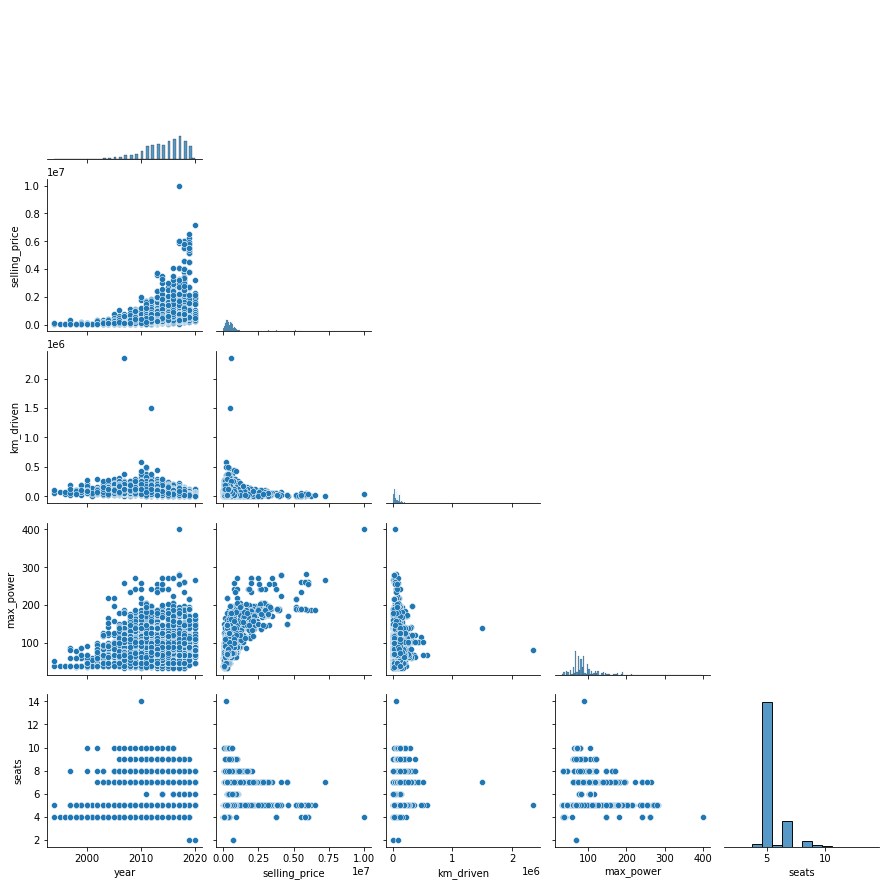

In [ ]:
# посмотрим на корреляции между признаками
sns.pairplot(dataset,corner=True)

Здесь можно отметить зависимость цены, пробега, количества сидений. Также видны выбросы

Закодируем категориальные признаки с помощью OneHotEncoding

In [36]:
my_cols = ['seller_type', 'transmission', 'fuel', 'owner']
train_predictors = dataset[my_cols]

In [37]:
train_predictors.dtypes

seller_type     object
transmission    object
fuel            object
owner           object
dtype: object

In [38]:
one_hot_encoded_predictors = pd.get_dummies(train_predictors)

In [43]:
one_hot_encoded_predictors.shape

(7907, 14)

In [44]:
dataset.shape

(7907, 11)

In [47]:
old_dt = dataset

In [48]:
dataset = pd.concat([dataset,one_hot_encoded_predictors],axis=1)

In [49]:
dataset.drop(columns=my_cols, axis=1,inplace=True)

In [50]:
dataset.head()

,year,selling_price,km_driven,mileage,engine,max_power,seats,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2014,450000,145500,23.4,1248,74.000000,5.0,0,1,0,0,1,0,1,0,0,1,0,0,0,0
1,2014,370000,120000,21.14,1498,103.519997,5.0,0,1,0,0,1,0,1,0,0,0,0,1,0,0
2,2006,158000,140000,17.7,1497,78.000000,5.0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
3,2010,225000,127000,23.0,1396,90.000000,5.0,0,1,0,0,1,0,1,0,0,1,0,0,0,0
4,2007,130000,120000,16.1,1298,88.199997,5.0,0,1,0,0,1,0,0,0,1,1,0,0,0,0


In [51]:
# уберем выбросы с помощью zscore
dataset = dataset[(np.abs(stats.zscore(dataset.km_driven)) < 3)]
dataset = dataset[(np.abs(stats.zscore(dataset.seats)) < 3)]
dataset = dataset[(np.abs(stats.zscore(dataset.selling_price)) < 3)]

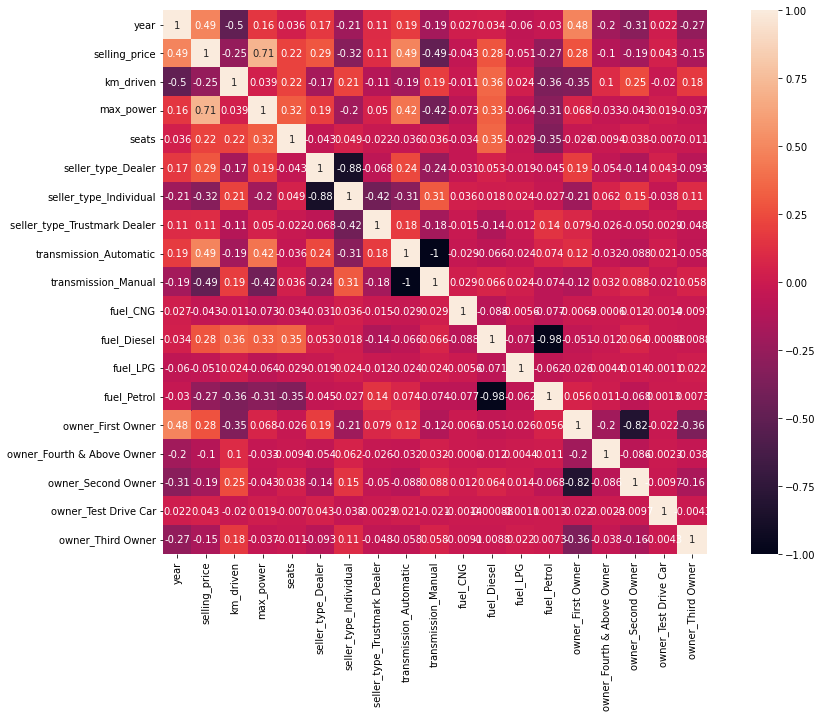

In [53]:
# посмотрим теперь на корреляционную матрицу
plt.figure(figsize=(16,10))
ax=plt.subplot(111)
sns.heatmap(dataset.corr(),annot=True,square=True)

Построим теперь линейную модель, чтобы посмотреть на точность прогноза до кроссвалидации

In [54]:
X = dataset.drop(columns=['selling_price'])
y = dataset.selling_price

In [55]:
X_ = X.to_numpy()
y_ = y.to_numpy()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 1/3)

In [58]:
linReg = linear_model.LinearRegression()

In [59]:
Lreg_fitted = linReg.fit(X_train,y_train)

Посмотрим на важность фичей

Feature: 0, importance: 32614.61255
Feature: 1, importance: -1.51467
Feature: 2, importance: -3644.26634
Feature: 3, importance: 89.74503
Feature: 4, importance: 6430.66468
Feature: 5, importance: -11153.44660
Feature: 6, importance: 20410.90652
Feature: 7, importance: -47938.05118
Feature: 8, importance: 27527.14466
Feature: 9, importance: 115445.94506
Feature: 10, importance: -115445.94506
Feature: 11, importance: -29093.76628
Feature: 12, importance: 53563.53747
Feature: 13, importance: 53466.87364
Feature: 14, importance: -77936.64483
Feature: 15, importance: -74583.12080
Feature: 16, importance: -103180.88169
Feature: 17, importance: -118732.39940
Feature: 18, importance: 407774.23779
Feature: 19, importance: -111277.83590


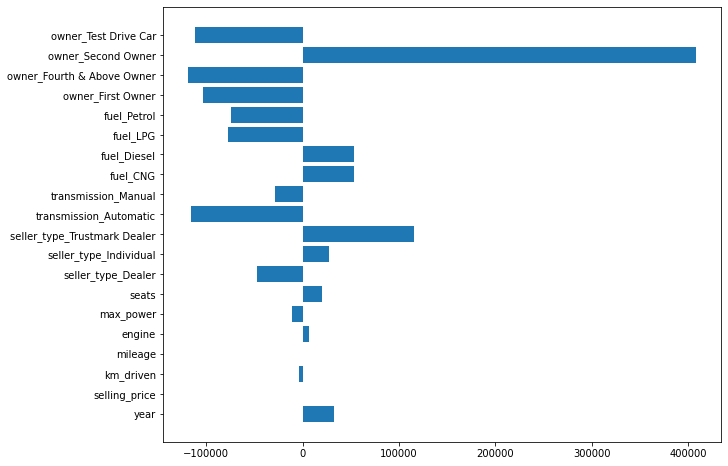

In [108]:
# get importance
importance = Lreg_fitted.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, importance: %.5f' % (i,v))
# plot feature importance
fig = plt.figure(figsize=(10,8))
plt.barh([dataset.columns[x] for x in range(len(importance))],importance)
plt.show()

In [98]:
importance

array([ 3.26146125e+04, -1.51467250e+00, -3.64426634e+03,  8.97450288e+01,
        6.43066468e+03, -1.11534466e+04,  2.04109065e+04, -4.79380512e+04,
        2.75271447e+04,  1.15445945e+05, -1.15445945e+05, -2.90937663e+04,
        5.35635375e+04,  5.34668736e+04, -7.79366448e+04, -7.45831208e+04,
       -1.03180882e+05, -1.18732399e+05,  4.07774238e+05, -1.11277836e+05])

Получим score на обучающей и тестовой выборках

In [60]:
Lreg_fitted.score(X_train, y_train)

0.7098069281202805

In [61]:
Lreg_fitted.score(X_test, y_test)

0.7245061603140988

Создадим класс списка, в котором будут хранится кроссвалидационные модели

In [76]:
class myList(object):

    def __init__(self):
        self.item = []

    def __repr__(self):
        return "{}".format(self.item)

    def __str__(self):
        return "{}".format(self.item)

    def add(self, add):
        self.item.append(add)
        return True

    def cls(self):
        self.item.clear()
        return True        

    def size(selft):
        return len(self.item)

    def isempty(self):
        if len(self.item) == 0:
            return True
        else:
            return False
            
    def get(self, index):
        if len(self.item) == 0:
            return None
        else:
            return self.item[index]

Создадим функцию, которая будет выдавать модели

In [73]:
def benchmark_models(X, y, split, my_List):
    my_List.cls()
    """
    Helper function to benchmark models
    X : array
    y : array
    split : tuple
     Training and test indices (train_idx, test_idx)
    """
    X_train, y_train = X[split[0],:], y[split[0]]
    X_test, y_test = X[split[1],:], y[split[1]]
    
    
    model_library = {}
    # One candidate model
    # model_library["logit"] = linear_model.LogisticRegression(solver='liblinear')
    # Another candidate model
    model_library["linreg"] = linear_model.LinearRegression()

    results = {}
    for model_name, model in model_library.items():
        # Train the model
        retModel = model.fit(X_train, y_train)
        # Evaluate the model
    
    my_List.add(retModel)

Разобьем выборку на фолды с помощью StratifiedKFold

In [64]:
splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
folds = list(splitter.split(X_, y_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


In [77]:
# создадим пустой глобальный список
global my_List_wmp
my_List_wmp = myList()

In [88]:
# создадим пустой глобальный список для хранения моделей, 
# полученных с помощью распаралелливания
global my_List_mp
my_List_mp = myList()

In [80]:
# предикт для ансамбля моделей, полученных с помощью CV
def CVpredict(X, models):
    sum = np.zeros(len(X))
    num_of_models = len(models.item)
    for model in models.item:
        sum = [a_ + b_ for a_,b_ in zip(sum,model.predict(X))]
    return [s/num_of_models for s in sum]

In [81]:
# score для ансамбля моделей, полученных с помощью CV
def CVscore(X, y, models):
    sum = 0
    for model in models.item:
        sum += model.score(X, y)
    return sum/len(models.item)

# Тестирование кроссвалидации без распаралелливания

In [120]:
time_w = []
for _ in range(0,10):
    time.sleep(1)
    time_start = time.time()
    for fold in folds:
        benchmark_models(X_,y_,folds[0],my_List_wmp)
    time_w.append(time.time() - time_start)    
    print("Потраченное время: ",time.time() - time_start)

Потраченное время:  0.030998945236206055
Потраченное время:  0.030853271484375
Потраченное время:  0.0332341194152832
Потраченное время:  0.031005382537841797
Потраченное время:  0.030905961990356445
Потраченное время:  0.031230688095092773
Потраченное время:  0.031170368194580078
Потраченное время:  0.031198978424072266
Потраченное время:  0.03062605857849121
Потраченное время:  0.03052687644958496


In [83]:
my_List.get(1).predict(X_train)

array([745937.1778613 , 771748.37264188, 509973.67561229, ...,
       678383.48153736, 516783.263295  , 584178.76754704])

In [91]:
CVpredict(X_test,my_List_wmp)[0:5]

[819581.3529844806,
 998347.9144152999,
 285847.3893168047,
 760668.3943024799,
 480318.26821707934]

In [92]:
CVscore(X_test,y_test,my_List_wmp)

0.7255274893926966

In [93]:
CVscore(X_train,y_train,my_List_wmp)

0.7091059271526343

# Тестирование кроссвалидации c распаралелливанием

In [118]:
result_mp = []
for _ in range(0,10):
    time.sleep(1)
    time_start = time.time()
    for fold in folds:
        my_thread = threading.Thread(target=benchmark_models, args=(X_, y_, fold, my_List_mp))
        my_thread.start()  
    result_mp.append(time.time() - time_start)
    print("Потраченное время: ",time.time() - time_start)

Потраченное время:  0.011425971984863281
Потраченное время:  0.0025038719177246094
Потраченное время:  0.0024633407592773438
Потраченное время:  0.006529331207275391
Потраченное время:  0.0060389041900634766
Потраченное время:  0.002299070358276367
Потраченное время:  0.002357959747314453
Потраченное время:  0.0024607181549072266
Потраченное время:  0.006767749786376953
Потраченное время:  0.0022640228271484375


In [95]:
CVscore(X_test,y_test,my_List_wmp)

0.7255274893926966

In [94]:
CVscore(X_train,y_train,my_List_mp)

0.7091586505386869

Графики времени выполнения

Text(0, 0.5, 'Время выполнения кросс-валидации')

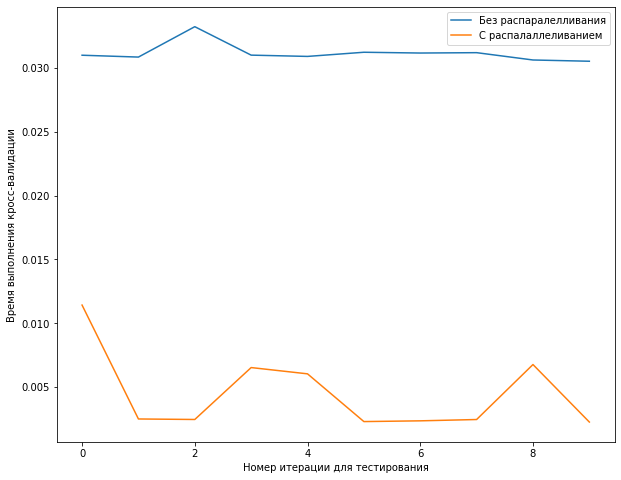

In [122]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(0,10),time_w)
plt.plot(range(0,10),result_mp)
plt.legend(['Без распаралелливания','С распалаллеливанием'])
plt.xlabel("Номер итерации для тестирования")
plt.ylabel("Время выполнения кросс-валидации")